# Albumentations Modeling Notebook

## Importing Packages

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


## Setting up ImageDataGenerators

In [2]:
# datagen = build_datagenerator(dir1 = "../sample/train",
#                               dir2 = "../sample/aug",
#                               batch_size = 16)

Found 3216 images belonging to 2 classes.
Found 614 images belonging to 2 classes.


In [61]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 244),
        batch_size = 32,
        class_mode = 'binary',
        seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 3830 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


## CNN Model

In [62]:
def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=4096, activation='relu'),
        layers.Dense(units=1, activation='sigmoid')
        ])
        # sigmoid also

model = create_model((224, 224, 3))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')],
              run_eagerly = True)


In [63]:
filepath = '../models/CNN_v2.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              verbose = 1,
                              epochs = 10,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator,
                              steps_per_epoch = int(239/16))

Epoch 1/10
 10/119 [=>............................] - ETA: 43:40 - loss: 176.7225 - accuracy: 0.5086 - precision_5: 0.6240 - recall_5: 0.5308 - auc_10: 0.5415 - auc_11: 0.6783

KeyboardInterrupt: 

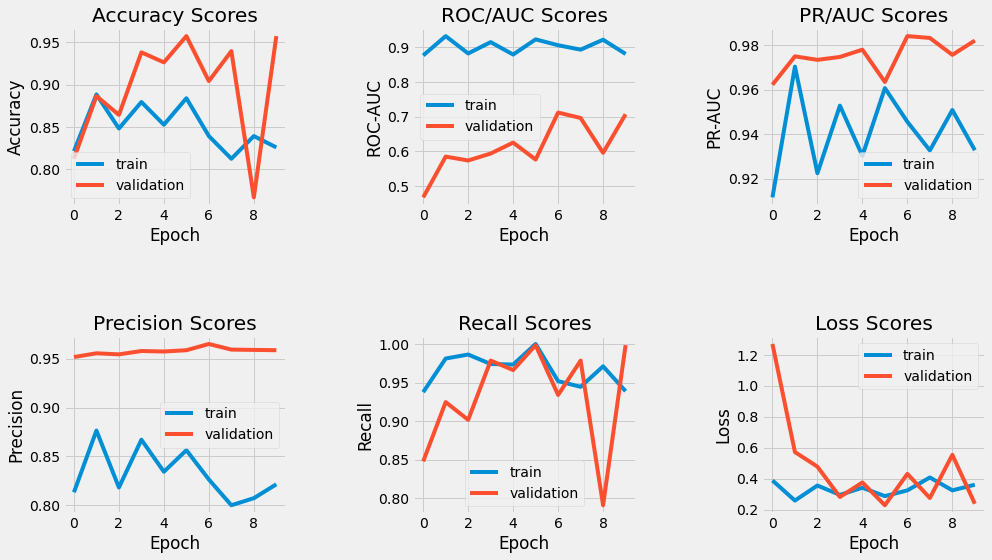

In [15]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [16]:
hist_df_1 = pd.DataFrame(history.history)
hist_df_1

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1
0,0.388307,0.821429,0.813253,0.937500,0.876693,0.911576,1.270467,0.812684,0.951641,0.847692,0.466951,0.962202
1,0.258172,0.888393,0.876405,0.981132,0.932511,0.970341,0.571774,0.886431,0.955485,0.924615,0.584643,0.974945
2,0.355431,0.848214,0.818182,0.986301,0.882420,0.922415,0.477406,0.864307,0.954397,0.901538,0.573407,0.973383
3,0.294965,0.879464,0.867052,0.974026,0.915074,0.952803,0.281357,0.938053,0.957831,0.978462,0.593462,0.974681
4,0.341141,0.852679,0.834286,0.973333,0.879324,0.930262,0.375293,0.926254,0.957317,0.966154,0.625082,0.977952
5,0.286811,0.883929,0.856354,1.000000,0.923048,0.960677,0.227949,0.957227,0.958641,0.998462,0.575962,0.963447
6,0.323941,0.839286,0.826347,0.951724,0.906155,0.945543,0.430765,0.904130,0.965024,0.933846,0.711758,0.984051
7,0.407510,0.812500,0.800000,0.944444,0.893403,0.932675,0.274736,0.939528,0.959276,0.978462,0.696126,0.983217
8,0.324102,0.839286,0.807229,0.971014,0.922059,0.950832,0.553679,0.766962,0.958955,0.790769,0.595440,0.975621
9,0.360459,0.825893,0.821429,0.938776,0.880952,0.932772,0.237545,0.957227,0.958641,0.998462,0.706896,0.982051


In [58]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

- Accuracy is not useful for extremely imbalance datasets.  High Accuracy is easily achieved by just predicting majority class.
- Precision tells us how many of the correctly predicted cases actually turned out to be positive. 
- Recall tells us how many of the actual positive cases we were able to predict correctly with our model.  Recall is a useful metric in cases where False Negative trumps False Positive.
- 

# VGG16

In [39]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224, 224, 3))

for layer in vgg16.layers:
    layer.trainable = False

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model2 = Model(inputs=input_, outputs=last_layer)

model2.compile(optimizer = Adam(learning_rate=0.01), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])


In [40]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [41]:
filepath = '../models/CNN_v3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history3 = model2.fit_generator(generator = datagen,
                                verbose = 1,
                                epochs = 20,
                                callbacks = [earlyStopping, mcp_save],
                                validation_data = val_generator,
                                steps_per_epoch = int(239/16)) 

Epoch 1/20
14/14 [==============================] - 214s 16s/step - loss: 2.3746 - accuracy: 0.6548 - precision_3: 0.7153 - recall_3: 0.6959 - auc_6: 0.6812 - auc_7: 0.7649 - val_loss: 0.8371 - val_accuracy: 0.8776 - val_precision_3: 0.9595 - val_recall_3: 0.9108 - val_auc_6: 0.5680 - val_auc_7: 0.9649
Epoch 2/20
14/14 [==============================] - 231s 17s/step - loss: 0.5604 - accuracy: 0.8936 - precision_3: 0.9168 - recall_3: 0.9287 - auc_6: 0.9074 - auc_7: 0.9332 - val_loss: 0.8084 - val_accuracy: 0.8805 - val_precision_3: 0.9656 - val_recall_3: 0.9077 - val_auc_6: 0.6675 - val_auc_7: 0.9746
Epoch 3/20
14/14 [==============================] - 215s 16s/step - loss: 0.7909 - accuracy: 0.8567 - precision_3: 0.9037 - recall_3: 0.8882 - auc_6: 0.8953 - auc_7: 0.9285 - val_loss: 1.1012 - val_accuracy: 0.7817 - val_precision_3: 0.9736 - val_recall_3: 0.7938 - val_auc_6: 0.7539 - val_auc_7: 0.9849
Epoch 4/20
14/14 [==============================] - 232s 17s/step - loss: 0.5411 - accur

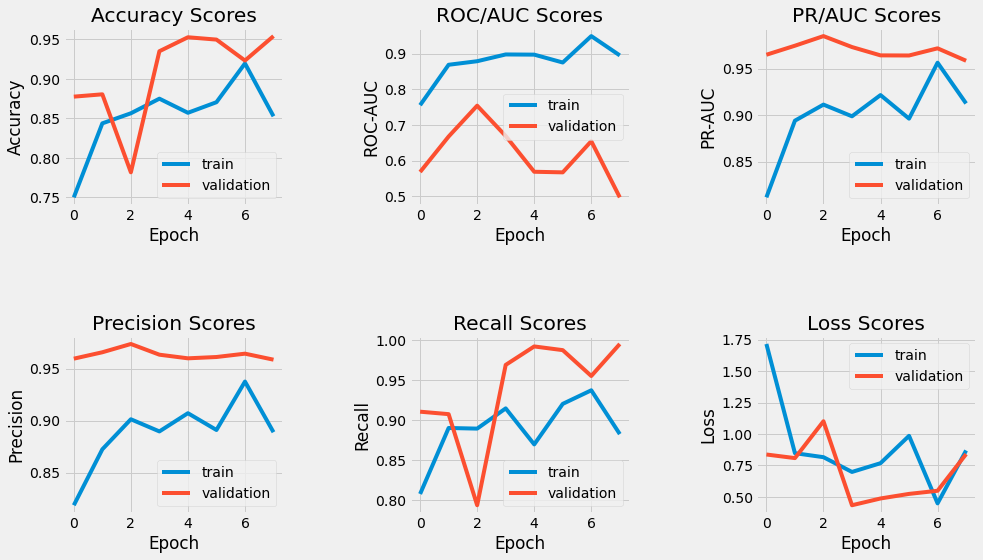

In [42]:
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

In [49]:
hist_df_2 = pd.DataFrame(history3.history)
hist_df_2

,loss,accuracy,precision_3,recall_3,auc_6,auc_7,val_loss,val_accuracy,val_precision_3,val_recall_3,val_auc_6,val_auc_7
0,1.715266,0.750000,0.818792,0.807947,0.755330,0.811751,0.837055,0.877581,0.959481,0.910769,0.568022,0.964906
1,0.847626,0.843750,0.872483,0.890411,0.868590,0.894093,0.808449,0.880531,0.965630,0.907692,0.667500,0.974601
2,0.815751,0.856502,0.901316,0.889610,0.878553,0.911363,1.101205,0.781711,0.973585,0.793846,0.753901,0.984922
3,0.698417,0.875000,0.889655,0.914894,0.897505,0.898803,0.433854,0.935103,0.963303,0.969231,0.668984,0.973168
4,0.767913,0.857143,0.907143,0.869863,0.896997,0.921591,0.487553,0.952802,0.959821,0.992308,0.568681,0.964229
5,0.985381,0.870536,0.891026,0.920530,0.874943,0.896293,0.524007,0.949853,0.961078,0.987692,0.567006,0.964106
6,0.448836,0.919643,0.937500,0.937500,0.948958,0.956368,0.548756,0.923304,0.964286,0.955385,0.654396,0.971795
7,0.869022,0.852679,0.888889,0.882759,0.894850,0.912589,0.840088,0.954277,0.958519,0.995385,0.496923,0.958458


In [ ]:
probabilities2 = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities2 > 0.5
make_confusion_matrix(y_true, y_pred)